"""
📁 PlantVillage Dataset Splitter
This script takes the original PlantVillage dataset — which contains one folder per class — 
and splits each class into 80% training and 20% validation images.

🔧 Output:
Creates a new directory 'PlantVillage_Split/' with two subfolders:
- train/ : contains 80% of images from each class
- val/   : contains 20% of images from each class

🎯 Purpose:
Keras and TensorFlow models expect the data to be arranged in this way when using 
ImageDataGenerator.flow_from_directory(). It helps the model generalize better by validating on unseen data.

In [1]:
import os
import shutil
import random
from pathlib import Path

# Paths
original_dataset = Path(r"C:\Users\kirti\Desktop\Desktop47\IEEE\PlantVillage Dataset\PlantVillage")  # Where your original data is
output_base = Path("PlantVillage_Split")  # New folder with train/ and val/

train_dir = output_base / "train"
val_dir = output_base / "val"

# Create directories
for label_dir in original_dataset.iterdir():
    if label_dir.is_dir():
        label = label_dir.name
        images = list(label_dir.glob("*.jpg"))
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        # Create class folders
        (train_dir / label).mkdir(parents=True, exist_ok=True)
        (val_dir / label).mkdir(parents=True, exist_ok=True)

        # Copy files
        for img in train_imgs:
            shutil.copy(img, train_dir / label / img.name)
        for img in val_imgs:
            shutil.copy(img, val_dir / label / img.name)

print("✅ Dataset split into train/ and val/ complete!")


✅ Dataset split into train/ and val/ complete!


To create label_map.json so that it can do accurate Prediction

In [3]:
import os
import json

# Path to your training folder
train_dir = r"C:\Users\kirti\Desktop\Desktop47\IEEE\PlantVillage_Split\train"

# Get all folder (class) names and sort them alphabetically to ensure consistent indexing
classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Map each class to an index
label_map = {cls: idx for idx, cls in enumerate(classes)}

# Save to JSON file
with open("label_map.json", "w") as f:
    json.dump(label_map, f)

print("✅ label_map.json created with", len(classes), "classes.")


✅ label_map.json created with 16 classes.


# 🌾 Plant Disease Detection and NDVI Estimation
This notebook contains two main components:

1. CNN-based Plant Disease Detection using Keras
2. NDVI Estimation from Red and NIR band images using OpenCV

!pip install tensorflow opencv-python matplotlib numpy

## Part A: CNN-Based Plant Disease Detection

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"C:\Users\kirti\Desktop\Desktop47\IEEE\PlantVillage_Split"  # Path to your dataset

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    'PlantVillage_Split/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    'PlantVillage_Split/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 16502 images belonging to 16 classes.
Found 4134 images belonging to 16 classes.


In [2]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [3]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
)

Epoch 1/30
516/516 [==============================] - 116s 224ms/step - loss: 1.1977 - accuracy: 0.6154 - val_loss: 0.7794 - val_accuracy: 0.7499
Epoch 2/30
516/516 [==============================] - 109s 210ms/step - loss: 0.4987 - accuracy: 0.8345 - val_loss: 0.5442 - val_accuracy: 0.8142
Epoch 3/30
516/516 [==============================] - 121s 235ms/step - loss: 0.2751 - accuracy: 0.9087 - val_loss: 0.4509 - val_accuracy: 0.8510
Epoch 4/30
516/516 [==============================] - 100s 193ms/step - loss: 0.1557 - accuracy: 0.9482 - val_loss: 0.3920 - val_accuracy: 0.8749
Epoch 5/30
516/516 [==============================] - 95s 185ms/step - loss: 0.1003 - accuracy: 0.9684 - val_loss: 0.5664 - val_accuracy: 0.8464
Epoch 6/30
516/516 [==============================] - 96s 186ms/step - loss: 0.0724 - accuracy: 0.9766 - val_loss: 0.4850 - val_accuracy: 0.8684
Epoch 7/30
516/516 [==============================] - 96s 186ms/step - loss: 0.0657 - accuracy: 0.9782 - val_loss: 0.6367 - va

In [4]:
model.save('plant_disease_cnn_model.h5')

In [5]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = r"C:\Users\kirti\Desktop\Desktop47\IEEE\PlantVillage_Split\train\Tomato_Late_blight\00ce4c63-9913-4b16-898c-29f99acf0dc3___RS_Late.B 4982.JPG"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_index = np.argmax(pred)
class_labels = list(train_gen.class_indices.keys())

print("Predicted Class:", class_labels[class_index])

1/1 [==============================] - 0s 472ms/step
Predicted Class: Tomato_Late_blight


## Part B: NDVI Estimation from NIR and Red Band Images

In [6]:
import os
print(os.path.exists('red_band.jpg'))

False


In [7]:
!pip install rasterio matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable


✅ Bands loaded successfully.
Red shape: (84, 183), NIR shape: (84, 183)


C:\ProgramData\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


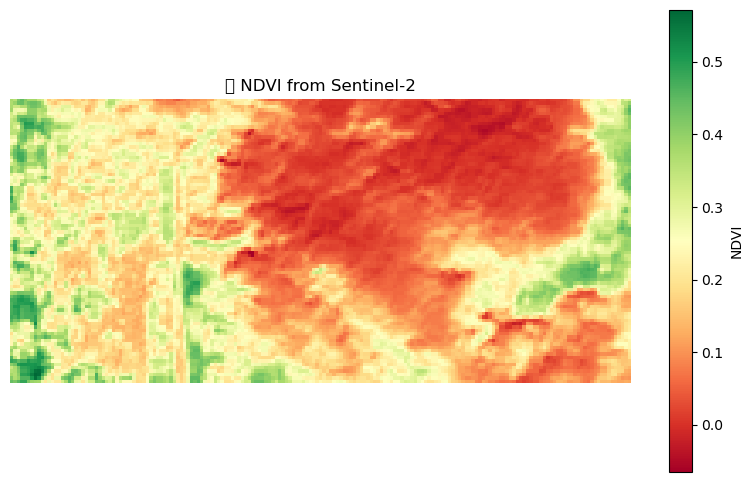

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Provide the correct file names for your downloaded Sentinel-2 bands
red_band_path = r"C:\Users\kirti\Desktop\Desktop47\IEEE\EO_Browser_images\red_band.tif.tiff"   # This should be B04
nir_band_path = r"C:\Users\kirti\Desktop\Desktop47\IEEE\EO_Browser_images\nir_band.tif.tiff"   # This should be B08

# Load the Red and NIR bands
with rasterio.open(red_band_path) as red_src:
    red = red_src.read(1).astype('float32')
    transform = red_src.transform  # save transform to write NDVI GeoTIFF

with rasterio.open(nir_band_path) as nir_src:
    nir = nir_src.read(1).astype('float32')

print("✅ Bands loaded successfully.")
print(f"Red shape: {red.shape}, NIR shape: {nir.shape}")

# Compute NDVI
ndvi = (nir - red) / (nir + red + 1e-10)
ndvi = np.clip(ndvi, -1, 1)

# Display NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title("🌿 NDVI from Sentinel-2")
plt.axis('off')
plt.show()


In [2]:
# Save NDVI as GeoTIFF for GIS or future use
with rasterio.open(
    'ndvi_output.tif',
    'w',
    driver='GTiff',
    height=ndvi.shape[0],
    width=ndvi.shape[1],
    count=1,
    dtype=ndvi.dtype,
    crs='EPSG:4326',
    transform=transform,
) as dst:
    dst.write(ndvi, 1)

print("✅ NDVI saved as ndvi_output.tif")


✅ NDVI saved as ndvi_output.tif
